<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/training_desi_complexdust_speculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/My Drive/speculator_fork


In [3]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from speculator import SpectrumPCA
from speculator import Speculator

In [4]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

In [5]:
n_param = 10
n_wave  = len(wave)
n_pcas  = 30 

In [6]:
# load trained PCA basis object
print('training PCA bases') 
PCABasis = SpectrumPCA(
        n_parameters=n_param,       # number of parameters
        n_wavelengths=n_wave,       # number of wavelength values
        n_pcas=n_pcas,              # number of pca coefficients to include in the basis 
        spectrum_filenames=None,  # list of filenames containing the (un-normalized) log spectra for training the PCA
        parameter_filenames=[], # list of filenames containing the corresponding parameter values
        parameter_selection=None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)
PCABasis._load_from_file('DESI_complexdust.0_99.seed0.pca.hdf5')

training PCA bases


In [7]:
# train Speculator 
training_theta  = tf.convert_to_tensor(PCABasis.training_parameters.astype(np.float32))
training_pca    = tf.convert_to_tensor(PCABasis.training_pca.astype(np.float32))

speculator = Speculator(
        n_parameters=n_param, # number of model parameters 
        wavelengths=wave, # array of wavelengths
        pca_transform_matrix=PCABasis.pca_transform_matrix,
        parameters_shift=PCABasis.parameters_shift, 
        parameters_scale=PCABasis.parameters_scale, 
        pca_shift=PCABasis.pca_shift, 
        pca_scale=PCABasis.pca_scale, 
        spectrum_shift=PCABasis.spectrum_shift, 
        spectrum_scale=PCABasis.spectrum_scale, 
        n_hidden=[256, 256, 256], # network architecture (list of hidden units per layer)
        restore=False, 
        optimizer=tf.keras.optimizers.Adam()) # optimizer for model training

# cooling schedule
validation_split = 0.1
lr = [1e-3, 1e-4, 1e-5, 1e-6]
batch_size = [1000, 10000, 50000, int((1-validation_split) * training_theta.shape[0])]
gradient_accumulation_steps = [1, 1, 1, 10] # split the largest batch size into 10 when computing gradients to avoid memory overflow

# early stopping set up
patience = 20

# train using cooling/heating schedule for lr/batch-size
for i in range(len(lr)):
    print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))
    # set learning rate
    speculator.optimizer.lr = lr[i]

    # split into validation and training sub-sets
    n_validation = int(training_theta.shape[0] * validation_split)
    n_training = training_theta.shape[0] - n_validation
    training_selection = tf.random.shuffle([True] * n_training + [False] * n_validation)

    # create iterable dataset (given batch size)
    training_data = tf.data.Dataset.from_tensor_slices(
            (training_theta[training_selection], training_pca[training_selection])).shuffle(n_training).batch(batch_size[i])

    # set up training loss
    training_loss   = [np.infty]
    validation_loss = [np.infty]
    best_loss       = np.infty
    early_stopping_counter = 0

    # loop over epochs
    while early_stopping_counter < patience:

        # loop over batches
        for theta, pca in training_data:

            # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
            if gradient_accumulation_steps[i] == 1:
                loss = speculator.training_step(theta, pca)
            else:
                loss = speculator.training_step_with_accumulated_gradients(theta, pca, accumulation_steps=gradient_accumulation_steps[i])

        # compute validation loss at the end of the epoch
        validation_loss.append(speculator.compute_loss(training_theta[~training_selection], training_pca[~training_selection]).numpy())

        # early stopping condition
        if validation_loss[-1] < best_loss:
            best_loss = validation_loss[-1]
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            speculator.update_emulator_parameters()
            speculator.save('_DESI_complexdust_model.log')

            attributes = list([
                    list(speculator.W_), 
                    list(speculator.b_), 
                    list(speculator.alphas_), 
                    list(speculator.betas_), 
                    speculator.pca_transform_matrix_,
                    speculator.pca_shift_,
                    speculator.pca_scale_,
                    speculator.spectrum_shift_,
                    speculator.spectrum_scale_,
                    speculator.parameters_shift_, 
                    speculator.parameters_scale_,
                    speculator.wavelengths])

            # save attributes to file
            f = open('DESI_complexdust_model.log.pkl', 'wb')
            pickle.dump(attributes, f)
            f.close()
            print('Validation loss = %s' % str(best_loss))

learning rate = 0.001, batch size = 1000
--- pcas ---
[2675.69214 204.051544 293.185669 ... -0.524155259 0.218449265 -0.033653859]
[-63.3719139 44.4841766 -2.92131615 ... -0.011139066 0.00262985146 0.00521992892]
[592.220398 -17.2102871 -88.86689 ... -0.0127437022 -0.122192621 0.106779344]
[40.3898125 -21.185936 2.96766305 ... 0.00244131172 -0.000593001838 -0.00432472257]
[1289.53772 -1714.82556 -17.2155018 ... -0.715957284 0.0577440858 -0.415720165]
[-95.2195053 20.5181084 1.51744115 ... -0.00926654 -0.00220982567 0.00450725295]
[-143.041168 -129.867218 320.196625 ... 0.232738018 -0.0984559506 -0.544526696]
[4.09917593 23.8622131 -2.3626647 ... 0.00262775365 0.00510731526 -0.000490733073]
[338.919739 2123.42944 47.4457893 ... 0.41780892 -0.225001201 0.537775517]
[-30.2633724 11.7322407 2.94314837 ... -0.000317422906 -0.00300888228 0.00533668976]
[1900.04822 49.7012634 17.166357 ... -0.226036638 0.0580519624 -0.108757094]
[-63.3719139 44.4841766 -2.92131615 ... -0.011139066 0.002629851

In [8]:
# write out training selection
np.save('DESI_complexdust_model.trainig_selection.npy', training_selection)

In [9]:
speculator = Speculator(restore=True, restore_filename='_DESI_complexdust_model.log')

(0.0, 2.0)

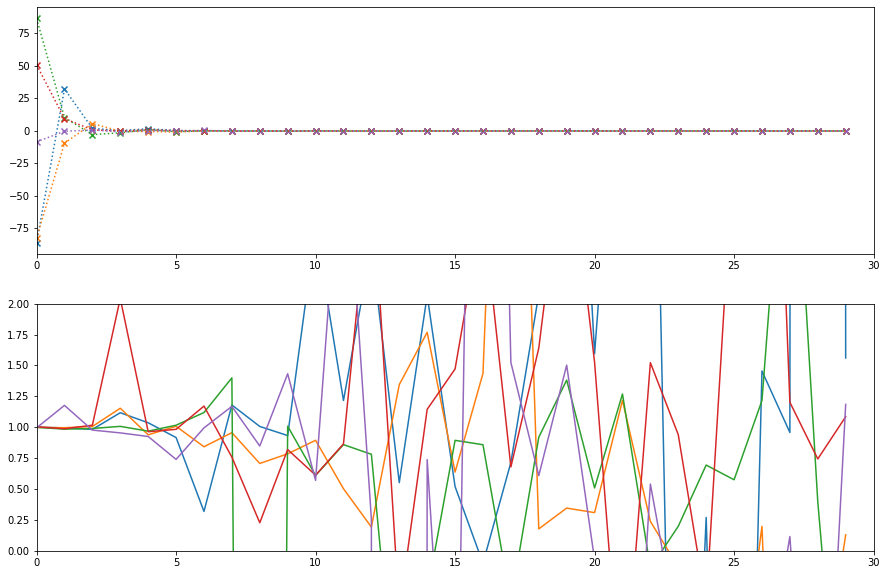

In [10]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(211)
for i, _theta, _pca in zip(range(5), training_theta[~training_selection][:5], speculator.call(training_theta[~training_selection][:5])): 
    sub.scatter(range(n_pcas), _pca, c='C%i' % i, marker='x') 
    sub.plot(PCABasis.training_pca[~training_selection][i], c='C%i' % i, ls=':') 
sub.set_xlim(0, n_pcas)

sub = fig.add_subplot(212)
for i, _theta, _pca in zip(range(5), training_theta[~training_selection][:5], speculator.call(training_theta[~training_selection][:5])): 
    sub.plot(range(n_pcas), _pca/PCABasis.training_pca[~training_selection][i], c='C%i' % i) 
sub.set_xlim(0, n_pcas)
sub.set_ylim(0., 2)